# Autoencoder Variacional en Generación de Imágenes
### Itzanami Berlanga Contreras | 12 de mayo del 2024

In [1]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random
#from tensorflow.framework import disable_eager_execution
#tf.compat.v1.disable_eager_execution()

BATCH_SIZE = 32 

IMG_WIDTH  = 96 
IMG_HEIGHT = 96 

ENCODING_SIZE = 8 

In [2]:
# create a flower generator with labels
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers",
    seed = 84,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE, 
    labels = 'inferred'
)

# keep the flower names for future reference
flower_names = flower_generator.class_names

# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers",
    seed = 42,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE, 
    labels = None, 
    validation_split = 0.2,
    subset = 'training'
)

# and a validation set generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers",
    seed = 42,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE, 
    labels = None, 
    validation_split = 0.2,
    subset = 'validation'
)

# autoencoders require the input matrix as both the input
# and the output
# provide input -> input for the autoencoder
# and, do scaling here
def replicate_inputs_to_outputs(images):
  return images/255, images/255

# create prefetch generators to speed things up a bit
training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

# create the final generators to be used in training the autoencoders
X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)

Found 15740 files belonging to 16 classes.
Found 15740 files.
Using 12592 files for training.
Found 15740 files.
Using 3148 files for validation.


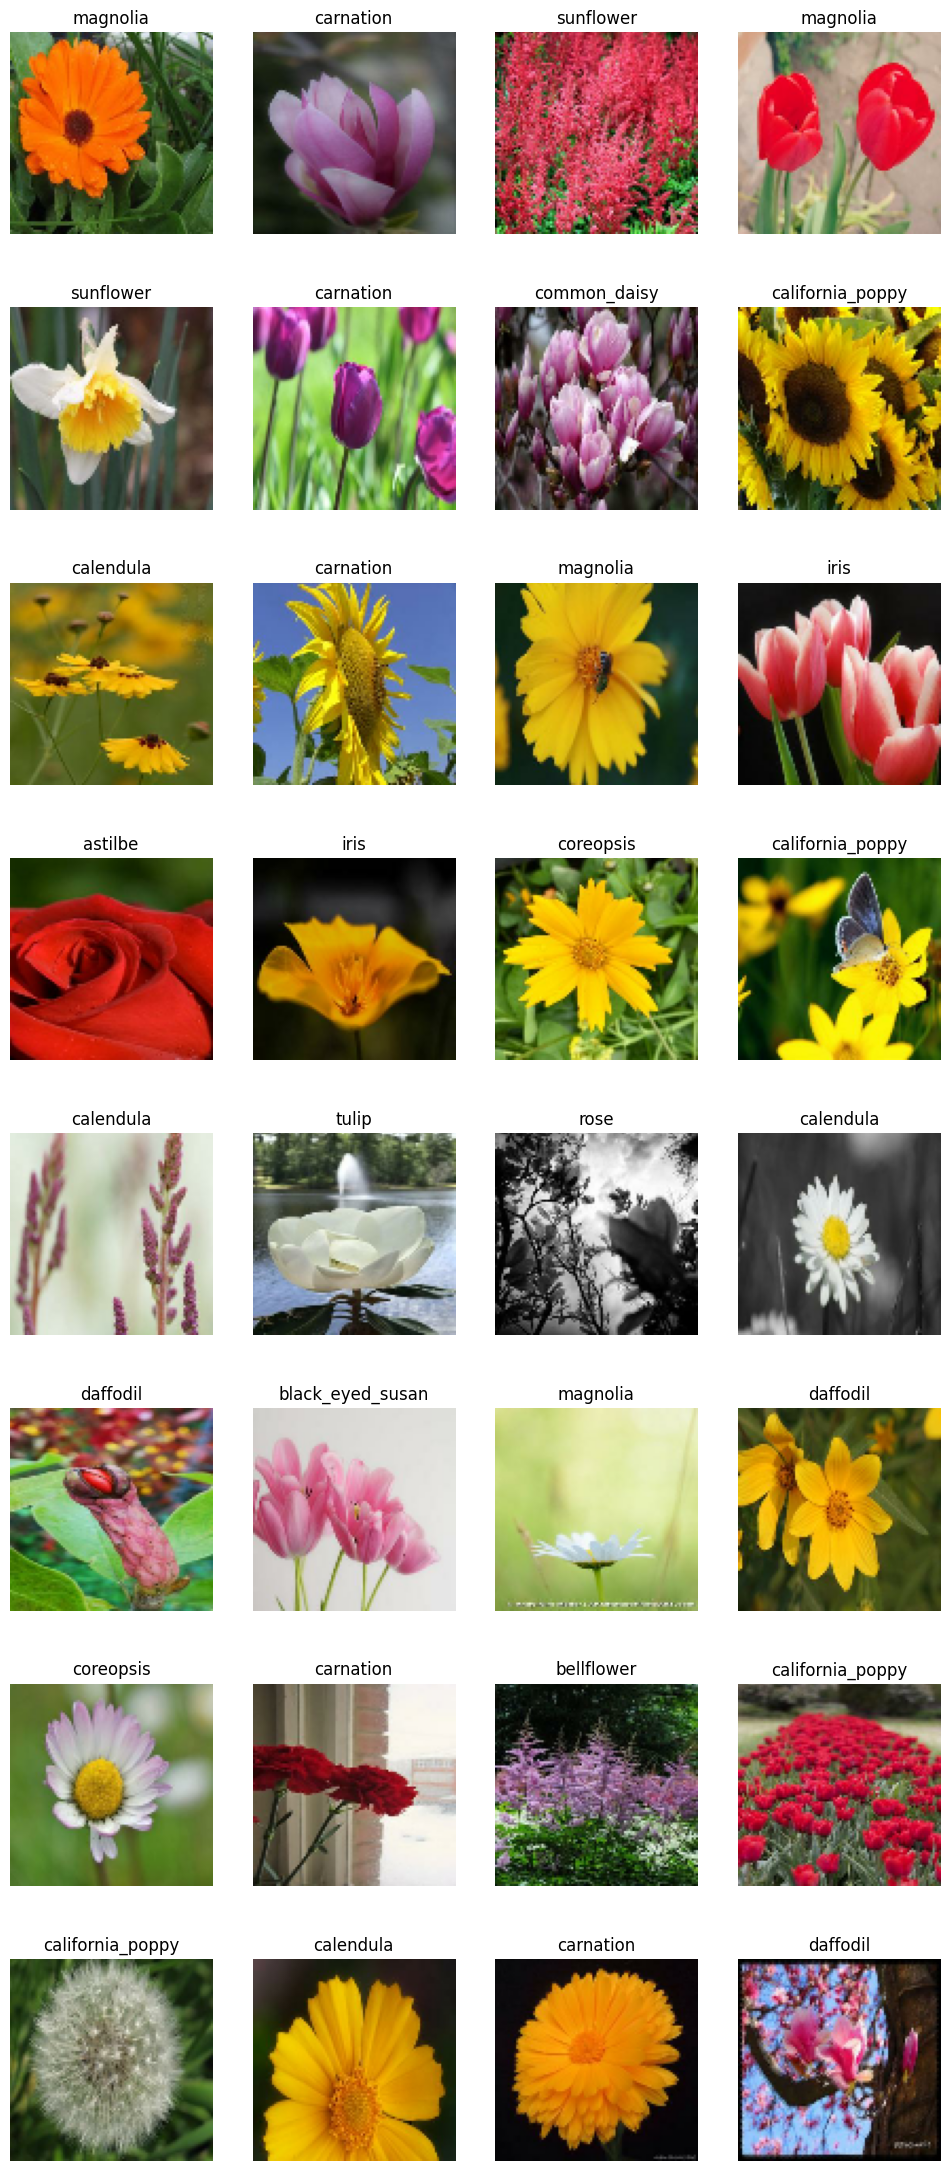

In [3]:
# visualize a few random flowers
plt.figure(figsize=(12, 28))

for images, labels in flower_generator.take(1):
  for i in range(len(images)):
      ax = plt.subplot(8, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(flower_names[labels[i]])
      plt.axis("off")

In [4]:
ENCODING_SIZE = 8 

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var /2) + mean

inputs = keras.layers.Input(shape = [IMG_WIDTH, IMG_HEIGHT, 3])
z = keras.layers.Conv2D(64, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                        strides = 1, padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(inputs)
z = keras.layers.Conv2D(128, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(256, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(512, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(ENCODING_SIZE)(z)
codings_log_var = keras.layers.Dense(ENCODING_SIZE)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs = [codings_mean, codings_log_var, codings])

variational_encoder.summary()

decoder_inputs = keras.layers.Input(shape = [ENCODING_SIZE])
x = keras.layers.Dense(512 * 12 * 12, activation = "selu", input_shape = [ENCODING_SIZE])(decoder_inputs)
x = keras.layers.Reshape([12, 12, 512])(x)
x = keras.layers.Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
outputs = keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = 1,
                                       padding = 'same', activation = 'sigmoid')(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

variational_decoder.summary()

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae = keras.Model(inputs = [inputs], outputs = [reconstructions])

vae.summary()

# add a loss function
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis = -1)
vae.add_loss(K.mean(latent_loss) / 27648.)

# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.0001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

vae.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam())
history = vae.fit(X_train, validation_data = X_valid,  epochs = 50, \
                  callbacks = [lr_scheduler, early_stopping_cb])

# visualize a few simulated flowers based on random sampling of means
random_codings = tf.random.normal(shape = [20, ENCODING_SIZE])
images = variational_decoder(random_codings).numpy()

plt.figure(figsize=(15, 12))

for i, image in enumerate(images):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image)
  plt.axis("off")

C:\Users\itzan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     73,856 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │    295,168 │ conv2d_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │  1,180,160 │ conv2d_2[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 73728)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │    589,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │    589,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,730,640 (10.42 MB)

 Trainable params: 2,730,640 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\itzan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 73728)          │       663,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 12, 12, 512)    │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 24, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 48, 48, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 96, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 96, 96, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,573,827 (17.45 MB)

 Trainable params: 4,573,827 (17.45 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: When providing `outputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: outputs=[[<KerasTensor shape=(None, 96, 96, 3), dtype=float32, sparse=False, name=keras_tensor_20>]] including invalid value [<KerasTensor shape=(None, 96, 96, 3), dtype=float32, sparse=False, name=keras_tensor_20>] of type <class 'list'>

In [6]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.0001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

vae.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam())
history = vae.fit(X_train, validation_data = X_valid,  epochs = 50, \
                  callbacks = [lr_scheduler, early_stopping_cb])

NameError: name 'vae' is not defined

## Referencias
- https://medium.com/vitrox-publication/generative-modeling-with-variational-auto-encoder-vae-fc449be9890e
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- 